In [185]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

In [187]:
from scripts.downloader import fetch_all_polls

In [188]:
all_polls = fetch_all_polls(cleanup=True, refresh=False)

In [189]:
all_polls

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,alliance,...,liberal,plaid_cymru,reform_uk,scottish_national_party,social_democratic_party,united_kingdom_independence_party,reclaim_party,others,lead,lead_value
0,2022-10-26,2022-10-27,Survation,NaN,UK,2028,27.0,51.0,8.0,NaN,...,NaN,1.0,3.0,5.0,NaN,0.0,NaN,3.0,lab+24.0,24.0
1,2022-10-26,2022-10-27,Techne UK,NaN,UK,1626,26.0,50.0,10.0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,lab+24.0,24.0
2,2022-10-24,2022-10-26,BMG Research,Independent,GB,TBC,26.0,49.0,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lab+23.0,23.0
3,2022-10-26,2022-10-26,PeoplePolling,GB News,GB,1237,20.0,51.0,9.0,NaN,...,NaN,NaN,7.0,5.0,NaN,NaN,NaN,5.0,lab+31.0,31.0
4,2022-10-25,2022-10-26,YouGov,The Times,GB,1646,23.0,51.0,9.0,NaN,...,NaN,1.0,6.0,5.0,NaN,NaN,NaN,1.0,lab+28.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918,1970-11-15,1970-11-15,Gallup,The Daily Telegraph,NaN,NaN,43.5,48.0,NaN,NaN,...,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lab+4.5,4.5
5919,1970-10-18,1970-10-18,Gallup,The Daily Telegraph,NaN,NaN,46.5,46.5,NaN,NaN,...,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tie,0.0
5920,1970-09-13,1970-09-13,Gallup,The Daily Telegraph,NaN,NaN,46.5,44.0,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,con+2.5,2.5
5921,1970-08-16,1970-08-16,Gallup,The Daily Telegraph,NaN,NaN,47.0,43.5,NaN,NaN,...,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,con+3.5,3.5


In [190]:
#all_polls = pd.read_csv('poll_database/poll_database.csv')

In [191]:
all_polls.to_csv('poll_database/poll_database.csv', index=False)
all_polls.to_excel('poll_database/poll_database.xlsx', index=False)
all_polls.to_json('poll_database/poll_database.json', index=False, orient='split')

In [192]:
display_columns = ['date_started', 'date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead']

In [193]:
all_polls['anti_conservative'] = all_polls[
    ['labour', 'liberal_democrat', 'green', 'scottish_national_party', 'plaid_cymru']].fillna(0).sum(axis=1)

In [194]:
all_polls[(all_polls.anti_conservative.fillna(0)) >= 75][
    ['date_concluded', 'pollster', 'labour', 'liberal_democrat', 'green', 'scottish_national_party', 'plaid_cymru',
     'anti_conservative', 'lead']]

,date_concluded,pollster,labour,liberal_democrat,green,scottish_national_party,plaid_cymru,anti_conservative,lead
8,2022-10-22,Omnisis,56.0,10.0,4.0,4.0,1.0,75.0,lab+34.0
10,2022-10-21,YouGov,56.0,10.0,4.0,4.0,1.0,75.0,lab+37.0
12,2022-10-20,PeoplePolling,53.0,11.0,6.0,5.0,NaN,75.0,lab+39.0
15,2022-10-19,Redfield & Wilton Strategies,55.0,12.0,4.0,4.0,NaN,75.0,lab+36.0
18,2022-10-16,Redfield & Wilton Strategies,56.0,11.0,5.0,4.0,NaN,76.0,lab+36.0
4470,1996-01-08,Gallup,60.5,14.5,NaN,NaN,NaN,75.0,lab+39.5
4482,1995-10-30,Gallup,61.0,14.5,NaN,NaN,NaN,75.5,lab+39.5
4516,1995-02-27,Gallup,60.5,15.0,NaN,NaN,NaN,75.5,lab+40.0
4523,1995-01-09,Gallup,62.0,14.0,NaN,NaN,NaN,76.0,lab+43.5
4552,1994-05-30,Gallup,54.0,21.5,NaN,NaN,NaN,75.5,lab+32.5


In [195]:
all_polls.query("liberal_democrat <7")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
340,2021-10-11,2021-10-18,Number Cruncher Politics,40.0,32.0,6.0,con+8.0
394,2021-07-23,2021-07-26,Deltapoll,42.0,37.0,6.0,con+5.0
408,2021-07-08,2021-07-09,Opinium,43.0,35.0,6.0,con+8.0
423,2021-06-16,2021-06-17,YouGov,45.0,31.0,6.0,con+14.0
425,2021-06-07,2021-06-14,Number Cruncher Politics,45.0,34.0,5.0,con+11.0
...,...,...,...,...,...,...,...
5100,1988-07-12,1988-07-12,Marplan,45.0,43.0,6.0,con+2.0
5109,1988-06-07,1988-06-07,Marplan,47.0,42.0,5.0,con+5.0
5112,1988-05-29,1988-05-29,Audience Selection,40.0,43.0,6.0,lab+3.0
5118,1988-04-26,1988-04-26,Ipsos MORI,44.0,42.0,6.0,con+2.0


In [196]:
all_polls.query("liberal_democrat + 4 > conservative")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
12,2022-10-20,2022-10-20,PeoplePolling,14.0,53.0,11.0,lab+39.0
859,2019-07-23,2019-07-24,YouGov,25.0,19.0,23.0,con+2.0
869,2019-06-24,2019-06-25,YouGov,22.0,20.0,19.0,Tie
873,2019-06-18,2019-06-19,YouGov,20.0,20.0,21.0,bre+2.0
874,2019-06-13,2019-06-14,YouGov,21.0,21.0,19.0,bre+3.0
875,2019-06-09,2019-06-10,YouGov,17.0,19.0,22.0,bre+4.0
878,2019-06-05,2019-06-06,YouGov,18.0,20.0,20.0,bre+6.0
879,2019-06-04,2019-06-05,YouGov,18.0,19.0,22.0,bre+3.0
880,2019-05-31,2019-06-01,YouGov,18.0,19.0,23.0,Tie
882,2019-05-28,2019-05-30,Opinium,17.0,22.0,16.0,bre+4.0


In [197]:
all_polls.query("pollster == 'YouGov' and green<brexit_party")[display_columns+['green','reform_uk','brexit_party']]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead,green,reform_uk,brexit_party
573,2020-11-04,2020-11-05,YouGov,35.0,40.0,7.0,lab+5.0,4.0,NaN,6.0
746,2019-11-25,2019-11-26,YouGov,43.0,32.0,13.0,con+11.0,2.0,NaN,4.0
757,2019-11-12,2019-11-20,YouGov,43.0,29.0,15.0,con+14.0,3.0,NaN,4.0
768,2019-11-14,2019-11-15,YouGov,45.0,28.0,15.0,con+17.0,3.0,NaN,4.0
777,2019-11-07,2019-11-08,YouGov,39.0,26.0,17.0,con+13.0,4.0,NaN,10.0
782,2019-11-05,2019-11-06,YouGov,36.0,25.0,17.0,con+11.0,5.0,NaN,11.0
785,2019-11-01,2019-11-04,YouGov,38.0,25.0,16.0,con+13.0,5.0,NaN,11.0
788,2019-10-30,2019-11-01,YouGov,39.0,27.0,16.0,con+12.0,4.0,NaN,7.0
792,2019-10-29,2019-10-30,YouGov,36.0,21.0,18.0,con+15.0,6.0,NaN,13.0
795,2019-10-17,2019-10-28,YouGov,36.0,22.0,19.0,con+14.0,6.0,NaN,12.0


In [198]:
all_polls[(all_polls.anti_conservative.fillna(0)) >= 15][
    ['date_concluded', 'pollster', 'labour', 'liberal_democrat', 'green', 'scottish_national_party', 'plaid_cymru',
     'anti_conservative', 'lead']]

,date_concluded,pollster,labour,liberal_democrat,green,scottish_national_party,plaid_cymru,anti_conservative,lead
0,2022-10-27,Survation,51.0,8.0,2.0,5.0,1.0,67.0,lab+24.0
1,2022-10-27,Techne UK,50.0,10.0,5.0,4.0,NaN,69.0,lab+24.0
2,2022-10-26,BMG Research,49.0,10.0,5.0,NaN,NaN,64.0,lab+23.0
3,2022-10-26,PeoplePolling,51.0,9.0,5.0,5.0,NaN,70.0,lab+31.0
4,2022-10-26,YouGov,51.0,9.0,4.0,5.0,1.0,70.0,lab+28.0
...,...,...,...,...,...,...,...,...,...
5918,1970-11-15,Gallup,48.0,NaN,NaN,NaN,NaN,48.0,lab+4.5
5919,1970-10-18,Gallup,46.5,NaN,NaN,NaN,NaN,46.5,Tie
5920,1970-09-13,Gallup,44.0,NaN,NaN,NaN,NaN,44.0,con+2.5
5921,1970-08-16,Gallup,43.5,NaN,NaN,NaN,NaN,43.5,con+3.5


In [199]:
all_polls.query("labour>conservative and lead_value>=35")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
10,2022-10-20,2022-10-21,YouGov,19.0,56.0,10.0,lab+37.0
12,2022-10-20,2022-10-20,PeoplePolling,14.0,53.0,11.0,lab+39.0
13,2022-10-20,2022-10-20,Omnisis,22.0,57.0,7.0,lab+35.0
15,2022-10-19,2022-10-19,Redfield & Wilton Strategies,19.0,55.0,12.0,lab+36.0
18,2022-10-16,2022-10-16,Redfield & Wilton Strategies,20.0,56.0,11.0,lab+36.0
4304,1997-11-27,1997-12-03,Gallup,21.0,57.0,17.0,lab+36.0
4308,1997-10-30,1997-11-04,Gallup,23.0,63.0,11.0,lab+40.0
4309,1997-10-24,1997-10-27,Ipsos MORI,24.0,60.0,12.0,lab+36.0
4310,1997-10-06,1997-10-06,ICM Research,23.0,59.0,13.0,lab+36.0
4311,1997-09-25,1997-10-01,Gallup,22.0,60.0,14.0,lab+38.0


In [200]:
all_polls.query("labour>55")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
8,2022-10-21,2022-10-22,Omnisis,22.0,56.0,10.0,lab+34.0
10,2022-10-20,2022-10-21,YouGov,19.0,56.0,10.0,lab+37.0
13,2022-10-20,2022-10-20,Omnisis,22.0,57.0,7.0,lab+35.0
18,2022-10-16,2022-10-16,Redfield & Wilton Strategies,20.0,56.0,11.0,lab+36.0
4230,1999-10-22,1999-10-25,Ipsos MORI,28.0,56.0,11.0,lab+28.0
...,...,...,...,...,...,...,...
4541,1994-08-22,1994-08-22,Ipsos MORI,23.0,56.0,18.0,lab+33.0
4543,1994-08-01,1994-08-01,Gallup,23.0,56.5,14.5,lab+33.5
4945,1990-04-07,1990-04-07,ICM Research,32.0,56.0,4.0,lab+24.0
4951,1990-03-22,1990-03-22,Harris Interactive,29.0,57.0,6.0,lab+28.0


In [201]:
all_polls.query("pollster=='Ipsos MORI' and labour>conservative and lead_value>=35")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
4309,1997-10-24,1997-10-27,Ipsos MORI,24.0,60.0,12.0,lab+36.0
4507,1995-05-22,1995-05-22,Ipsos MORI,22.0,58.0,16.0,lab+36.0
4524,1994-12-19,1994-12-19,Ipsos MORI,22.0,61.0,13.0,lab+39.0


In [202]:
all_polls.query("pollster=='ICM Research'")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
723,2019-12-06,2019-12-09,ICM Research,42.0,36.0,12.0,con+6.0
737,2019-11-29,2019-12-02,ICM Research,42.0,35.0,13.0,con+7.0
748,2019-11-22,2019-11-25,ICM Research,41.0,34.0,13.0,con+7.0
762,2019-11-15,2019-11-18,ICM Research,42.0,32.0,13.0,con+10.0
773,2019-11-08,2019-11-11,ICM Research,39.0,31.0,15.0,con+8.0
...,...,...,...,...,...,...,...
5034,1989-05-13,1989-05-13,ICM Research,43.0,43.0,8.0,Tie
5040,1989-04-08,1989-04-08,ICM Research,44.0,40.0,7.0,con+4.0
5047,1989-03-13,1989-03-13,ICM Research,41.0,39.0,8.0,con+2.0
5057,1989-02-11,1989-02-11,ICM Research,42.0,39.0,7.0,con+3.0


In [203]:
all_polls.query("pollster=='Savanta ComRes' and labour >42")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
6,2022-10-21,2022-10-23,Savanta ComRes,25.0,51.0,8.0,lab+26.0
19,2022-10-14,2022-10-16,Savanta ComRes,22.0,52.0,11.0,lab+30.0
27,2022-10-07,2022-10-09,Savanta ComRes,23.0,51.0,10.0,lab+28.0
36,2022-09-30,2022-10-02,Savanta ComRes,25.0,50.0,11.0,lab+25.0
50,2022-09-23,2022-09-25,Savanta ComRes,29.0,43.0,12.0,lab+14.0
60,2022-09-15,2022-09-16,Savanta ComRes,33.0,45.0,10.0,lab+12.0
111,2022-07-21,2022-07-21,Savanta ComRes,33.0,44.0,9.0,lab+11.0
115,2022-07-15,2022-07-17,Savanta ComRes,30.0,43.0,11.0,lab+13.0
120,2022-07-08,2022-07-10,Savanta ComRes,28.0,43.0,12.0,lab+15.0
251,2022-01-28,2022-01-30,Savanta ComRes,33.0,44.0,9.0,lab+11.0


In [204]:
all_polls.query("pollster=='Savanta ComRes' and lead_value >= 20")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
6,2022-10-21,2022-10-23,Savanta ComRes,25.0,51.0,8.0,lab+26.0
19,2022-10-14,2022-10-16,Savanta ComRes,22.0,52.0,11.0,lab+30.0
27,2022-10-07,2022-10-09,Savanta ComRes,23.0,51.0,10.0,lab+28.0
36,2022-09-30,2022-10-02,Savanta ComRes,25.0,50.0,11.0,lab+25.0
1252,2017-04-19,2017-04-20,Savanta ComRes,50.0,25.0,11.0,con+25.0
1258,2017-04-11,2017-04-13,Savanta ComRes,46.0,25.0,11.0,con+21.0
3745,2008-08-20,2008-08-21,Savanta ComRes,46.0,25.0,16.0,con+21.0
3755,2008-07-23,2008-07-24,Savanta ComRes,46.0,24.0,18.0,con+22.0
3758,2008-07-16,2008-07-17,Savanta ComRes,45.0,24.0,16.0,con+21.0
3761,2008-06-25,2008-06-26,Savanta ComRes,46.0,25.0,18.0,con+21.0


In [205]:
all_polls.query("labour>53")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
5,2022-10-25,2022-10-26,Redfield & Wilton Strategies,23.0,55.0,9.0,lab+32.0
7,2022-10-23,2022-10-23,Redfield & Wilton Strategies,21.0,54.0,11.0,lab+33.0
8,2022-10-21,2022-10-22,Omnisis,22.0,56.0,10.0,lab+34.0
10,2022-10-20,2022-10-21,YouGov,19.0,56.0,10.0,lab+37.0
13,2022-10-20,2022-10-20,Omnisis,22.0,57.0,7.0,lab+35.0
...,...,...,...,...,...,...,...
4952,1990-03-20,1990-03-20,Ipsos MORI,31.0,54.0,6.0,lab+23.0
5573,1980-12-19,1980-12-19,Gallup,32.0,56.0,NaN,lab+24.0
5907,1971-09-20,1971-09-20,Gallup,35.0,54.0,NaN,lab+19.0
5909,1971-07-12,1971-07-12,Gallup,33.5,55.0,NaN,lab+21.5


In [206]:
all_polls.query("conservative<29 and labour>conservative and lead_value>14")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2022-10-26,2022-10-27,Survation,27.0,51.0,8.0,lab+24.0
1,2022-10-26,2022-10-27,Techne UK,26.0,50.0,10.0,lab+24.0
2,2022-10-24,2022-10-26,BMG Research,26.0,49.0,10.0,lab+23.0
3,2022-10-26,2022-10-26,PeoplePolling,20.0,51.0,9.0,lab+31.0
4,2022-10-25,2022-10-26,YouGov,23.0,51.0,9.0,lab+28.0
...,...,...,...,...,...,...,...
4605,1993-05-31,1993-05-31,Gallup,25.0,49.0,23.0,lab+24.0
4606,1993-05-24,1993-05-24,Ipsos MORI,28.0,44.0,24.0,lab+16.0
4947,1990-04-02,1990-04-02,Gallup,28.0,52.5,7.5,lab+24.5
4950,1990-03-23,1990-03-23,ICM Research,28.0,55.0,7.0,lab+27.0


In [207]:
all_polls.loc[(all_polls.labour >= 50), 'maj_lead'] = 1
all_polls['maj_lead'] = all_polls['maj_lead'].fillna(0)
all_polls['maj_lead_in_row'] = 0
for ix, value in all_polls['maj_lead'].iteritems():
    if value >= 1:
        polls_before = all_polls.iloc[:ix]['maj_lead']
        polls_after = all_polls.iloc[ix:]['maj_lead']
        next_untrue_poll = polls_after[polls_after == 0].index[0]
        after_polls = next_untrue_poll - ix

        if len(polls_before[polls_before == 0]) == 0:
            before_polls = len(polls_before)
        else:
            last_untrue_poll = polls_before[polls_before == 0].index[-1]
            before_polls = (ix - last_untrue_poll) - 1

        total_polls = before_polls + after_polls
        all_polls.loc[ix, 'maj_lead_in_row'] = total_polls
    else:
        total_polls = 0

In [208]:
all_polls[all_polls['maj_lead_in_row'] > 5][
    ['date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead', 'maj_lead_in_row']].to_clipboard(sep='\t')

In [209]:
all_polls

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,alliance,...,scottish_national_party,social_democratic_party,united_kingdom_independence_party,reclaim_party,others,lead,lead_value,anti_conservative,maj_lead,maj_lead_in_row
0,2022-10-26,2022-10-27,Survation,NaN,UK,2028,27.0,51.0,8.0,NaN,...,5.0,NaN,0.0,NaN,3.0,lab+24.0,24.0,67.0,1.0,2
1,2022-10-26,2022-10-27,Techne UK,NaN,UK,1626,26.0,50.0,10.0,NaN,...,4.0,NaN,NaN,NaN,5.0,lab+24.0,24.0,69.0,1.0,2
2,2022-10-24,2022-10-26,BMG Research,Independent,GB,TBC,26.0,49.0,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,lab+23.0,23.0,64.0,0.0,0
3,2022-10-26,2022-10-26,PeoplePolling,GB News,GB,1237,20.0,51.0,9.0,NaN,...,5.0,NaN,NaN,NaN,5.0,lab+31.0,31.0,70.0,1.0,17
4,2022-10-25,2022-10-26,YouGov,The Times,GB,1646,23.0,51.0,9.0,NaN,...,5.0,NaN,NaN,NaN,1.0,lab+28.0,28.0,70.0,1.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918,1970-11-15,1970-11-15,Gallup,The Daily Telegraph,NaN,NaN,43.5,48.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,lab+4.5,4.5,48.0,0.0,0
5919,1970-10-18,1970-10-18,Gallup,The Daily Telegraph,NaN,NaN,46.5,46.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Tie,0.0,46.5,0.0,0
5920,1970-09-13,1970-09-13,Gallup,The Daily Telegraph,NaN,NaN,46.5,44.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,con+2.5,2.5,44.0,0.0,0
5921,1970-08-16,1970-08-16,Gallup,The Daily Telegraph,NaN,NaN,47.0,43.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,con+3.5,3.5,43.5,0.0,0


In [210]:
all_polls.loc[(all_polls.labour > all_polls.conservative) & (all_polls.lead_value >= 10), 'dd_lead'] = 1
all_polls['dd_lead'] = all_polls['dd_lead'].fillna(0)

In [211]:
all_polls.loc[(all_polls.lead_value >= 10), 'dd_lead'] = 1
all_polls['dd_lead'] = all_polls['dd_lead'].fillna(0)

In [212]:
all_polls['dd_in_row'] = 0

In [213]:
for ix, value in all_polls['dd_lead'].iteritems():
    if value >= 1:
        polls_before = all_polls.iloc[:ix]['dd_lead']
        polls_after = all_polls.iloc[ix:]['dd_lead']
        next_untrue_poll = polls_after[polls_after == 0].index[0]
        after_polls = next_untrue_poll - ix

        if len(polls_before[polls_before == 0]) == 0:
            before_polls = len(polls_before)
        else:
            last_untrue_poll = polls_before[polls_before == 0].index[-1]
            before_polls = (ix - last_untrue_poll) - 1

        total_polls = before_polls + after_polls
        all_polls.loc[ix, 'dd_in_row'] = total_polls
    else:
        total_polls = 0



In [214]:
all_polls[all_polls['dd_in_row'] > 22][
    ['date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead', 'dd_in_row']]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead,dd_in_row
0,2022-10-27,Survation,27.0,51.0,8.0,lab+24.0,48
1,2022-10-27,Techne UK,26.0,50.0,10.0,lab+24.0,48
2,2022-10-26,BMG Research,26.0,49.0,10.0,lab+23.0,48
3,2022-10-26,PeoplePolling,20.0,51.0,9.0,lab+31.0,48
4,2022-10-26,YouGov,23.0,51.0,9.0,lab+28.0,48
...,...,...,...,...,...,...,...
5462,1983-05-24,Gallup,45.0,32.0,NaN,con+13.0,43
5463,1983-05-23,Audience Selection,48.0,33.0,NaN,con+15.0,43
5464,1983-05-23,Ipsos MORI,45.0,32.0,NaN,con+13.0,43
5465,1983-05-23,NOP,51.0,33.0,NaN,con+18.0,43


In [215]:
polls_after

5914    1.0
5915    0.0
5916    0.0
5917    0.0
5918    0.0
5919    0.0
5920    0.0
5921    0.0
5922    0.0
Name: dd_lead, dtype: float64

In [216]:
before_polls

0

In [217]:
polls_after



5914    1.0
5915    0.0
5916    0.0
5917    0.0
5918    0.0
5919    0.0
5920    0.0
5921    0.0
5922    0.0
Name: dd_lead, dtype: float64

In [218]:
polls_before[polls_before == 0]

48      0.0
53      0.0
54      0.0
55      0.0
59      0.0
       ... 
5904    0.0
5905    0.0
5908    0.0
5912    0.0
5913    0.0
Name: dd_lead, Length: 4096, dtype: float64

In [219]:
all_polls.query("pollster=='Savanta ComRes' and labour>conservative and lead_value>=14")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
6,2022-10-21,2022-10-23,Savanta ComRes,25.0,51.0,8.0,lab+26.0
19,2022-10-14,2022-10-16,Savanta ComRes,22.0,52.0,11.0,lab+30.0
27,2022-10-07,2022-10-09,Savanta ComRes,23.0,51.0,10.0,lab+28.0
36,2022-09-30,2022-10-02,Savanta ComRes,25.0,50.0,11.0,lab+25.0
50,2022-09-23,2022-09-25,Savanta ComRes,29.0,43.0,12.0,lab+14.0
120,2022-07-08,2022-07-10,Savanta ComRes,28.0,43.0,12.0,lab+15.0


In [220]:
all_polls.query("lead_value >= 15 and labour>conservative")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2022-10-26,2022-10-27,Survation,27.0,51.0,8.0,lab+24.0
1,2022-10-26,2022-10-27,Techne UK,26.0,50.0,10.0,lab+24.0
2,2022-10-24,2022-10-26,BMG Research,26.0,49.0,10.0,lab+23.0
3,2022-10-26,2022-10-26,PeoplePolling,20.0,51.0,9.0,lab+31.0
4,2022-10-25,2022-10-26,YouGov,23.0,51.0,9.0,lab+28.0
...,...,...,...,...,...,...,...
5830,1974-04-16,1974-04-16,Gallup,33.0,49.0,NaN,lab+16.0
5879,1973-05-06,1973-05-06,NOP,31.9,50.1,NaN,lab+18.2
5907,1971-09-20,1971-09-20,Gallup,35.0,54.0,NaN,lab+19.0
5909,1971-07-12,1971-07-12,Gallup,33.5,55.0,NaN,lab+21.5


In [221]:
all_polls.query("lead_value >= 18 and labour>conservative")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2022-10-26,2022-10-27,Survation,27.0,51.0,8.0,lab+24.0
1,2022-10-26,2022-10-27,Techne UK,26.0,50.0,10.0,lab+24.0
2,2022-10-24,2022-10-26,BMG Research,26.0,49.0,10.0,lab+23.0
3,2022-10-26,2022-10-26,PeoplePolling,20.0,51.0,9.0,lab+31.0
4,2022-10-25,2022-10-26,YouGov,23.0,51.0,9.0,lab+28.0
...,...,...,...,...,...,...,...
5573,1980-12-19,1980-12-19,Gallup,32.0,56.0,NaN,lab+24.0
5879,1973-05-06,1973-05-06,NOP,31.9,50.1,NaN,lab+18.2
5907,1971-09-20,1971-09-20,Gallup,35.0,54.0,NaN,lab+19.0
5909,1971-07-12,1971-07-12,Gallup,33.5,55.0,NaN,lab+21.5


In [222]:
all_polls.query("conservative <29")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2022-10-26,2022-10-27,Survation,27.0,51.0,8.0,lab+24.0
1,2022-10-26,2022-10-27,Techne UK,26.0,50.0,10.0,lab+24.0
2,2022-10-24,2022-10-26,BMG Research,26.0,49.0,10.0,lab+23.0
3,2022-10-26,2022-10-26,PeoplePolling,20.0,51.0,9.0,lab+31.0
4,2022-10-25,2022-10-26,YouGov,23.0,51.0,9.0,lab+28.0
...,...,...,...,...,...,...,...
5543,1981-09-28,1981-09-28,Ipsos MORI,28.0,42.0,NaN,lab+14.0
5544,1981-09-18,1981-09-18,Gallup,27.0,38.0,NaN,lab+5.0
5547,1981-08-17,1981-08-17,NOP,28.0,38.5,NaN,lab+6.0
5565,1981-03-23,1981-03-23,Gallup,28.0,38.0,NaN,lab+6.0


In [223]:
all_polls.query("pollster=='YouGov' and liberal_democrat > 54")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead


In [224]:
all_polls.query("pollster=='Ipsos MORI' and liberal_democrat >=15")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
130,2022-06-22,2022-06-29,Ipsos MORI,30.0,41.0,15.0,lab+11.0
759,2019-11-15,2019-11-19,Ipsos MORI,44.0,28.0,16.0,con+16.0
794,2019-10-25,2019-10-28,Ipsos MORI,41.0,24.0,20.0,con+17.0
822,2019-09-13,2019-09-16,Ipsos MORI,33.0,24.0,23.0,con+9.0
852,2019-07-26,2019-07-30,Ipsos MORI,34.0,24.0,20.0,con+10.0
...,...,...,...,...,...,...,...
4817,1991-05-28,1991-05-28,Ipsos MORI,37.0,43.0,16.0,lab+6.0
4829,1991-04-22,1991-04-22,Ipsos MORI,42.0,40.0,15.0,con+2.0
4835,1991-03-25,1991-03-25,Ipsos MORI,40.0,40.0,16.0,Tie
4837,1991-03-22,1991-03-22,Ipsos MORI,38.0,44.0,15.0,lab+6.0


In [225]:
all_polls.query("pollster=='YouGov' and liberal_democrat >12")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
102,2022-07-27,2022-07-28,YouGov,34.0,35.0,13.0,lab+1.0
117,2022-07-13,2022-07-14,YouGov,29.0,40.0,13.0,lab+11.0
124,2022-07-06,2022-07-07,YouGov,29.0,40.0,15.0,lab+11.0
131,2022-06-28,2022-06-29,YouGov,33.0,36.0,13.0,lab+3.0
273,2022-01-11,2022-01-12,YouGov,28.0,38.0,13.0,lab+10.0
...,...,...,...,...,...,...,...
4058,2003-09-23,2003-09-25,YouGov,32.0,31.0,30.0,con+1.0
4063,2003-07-22,2003-07-24,YouGov,37.0,34.0,22.0,con+3.0
4068,2003-04-22,2003-04-24,YouGov,32.0,40.0,21.0,lab+8.0
4070,2003-03-26,2003-03-27,YouGov,33.0,40.0,20.0,lab+7.0


In [226]:
all_polls.query("labour + green >= 50")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2022-10-26,2022-10-27,Survation,27.0,51.0,8.0,lab+24.0
1,2022-10-26,2022-10-27,Techne UK,26.0,50.0,10.0,lab+24.0
2,2022-10-24,2022-10-26,BMG Research,26.0,49.0,10.0,lab+23.0
3,2022-10-26,2022-10-26,PeoplePolling,20.0,51.0,9.0,lab+31.0
4,2022-10-25,2022-10-26,YouGov,23.0,51.0,9.0,lab+28.0
5,2022-10-25,2022-10-26,Redfield & Wilton Strategies,23.0,55.0,9.0,lab+32.0
6,2022-10-21,2022-10-23,Savanta ComRes,25.0,51.0,8.0,lab+26.0
7,2022-10-23,2022-10-23,Redfield & Wilton Strategies,21.0,54.0,11.0,lab+33.0
8,2022-10-21,2022-10-22,Omnisis,22.0,56.0,10.0,lab+34.0
9,2022-10-19,2022-10-21,JL Partners Polls,26.0,51.0,8.0,lab+25.0


In [227]:
all_polls.query("pollster=='Opinium' and labour >= 41")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
11,2022-10-19,2022-10-21,Opinium,23.0,50.0,9.0,lab+27.0
31,2022-10-05,2022-10-07,Opinium,26.0,47.0,11.0,lab+21.0
38,2022-09-29,2022-09-30,Opinium,27.0,46.0,9.0,lab+19.0
269,2022-01-12,2022-01-14,Opinium,31.0,41.0,9.0,lab+10.0
297,2021-12-08,2021-12-10,Opinium,32.0,41.0,9.0,lab+9.0
535,2021-01-14,2021-01-15,Opinium,37.0,41.0,6.0,lab+4.0
571,2020-11-05,2020-11-06,Opinium,38.0,42.0,7.0,lab+4.0
596,2020-09-23,2020-09-25,Opinium,39.0,42.0,5.0,lab+3.0
1111,2017-12-12,2017-12-14,Opinium,39.0,41.0,7.0,lab+2.0
1124,2017-11-14,2017-11-16,Opinium,40.0,42.0,6.0,lab+2.0


In [228]:
#all_polls.query("pollster == 'YouGov' and conservative <31")[display_columns]

In [229]:
reporting_date = 'date_started'

In [230]:
most_recent_date = all_polls[reporting_date].max()
one_year_polls = all_polls[
    all_polls[reporting_date] >= (most_recent_date + relativedelta(months=-16)).replace(day=1)].copy()

In [231]:
pollsters_latest = pd.DataFrame()
for pollster in one_year_polls.pollster.unique():
    pollster_data = one_year_polls.query(f'pollster == "{pollster}"')
    latest_poll = pollster_data.iloc[0]
    pollsters_latest = pollsters_latest.append(latest_poll)

In [232]:
top_five = {'Ipsos MORI': 100,
            'Opinium': 79,
            'YouGov': 77,
            'Kantar Public': 69,
            'Number Cruncher Politics': 61,
            'Survation': 59,
            'Panelbase': 57,
            'Deltapoll': 46,
            'BMG Research': 44,
            'FocalData': 39,
            'ICM Research': 35,
            'Savanta ComRes': 34,
            'Find Out Now': 34*0.3,  # Ludicrous Local Election Polling
            'Redfield & Wilton Strategies': 34*.75,
            'Techne UK': 34*.75,
            'JL Partners Polls': 34*.75,
            'PeoplePolling': 34*.75,
            'Omnisis': 34*.75,
            }

top_two = {'Ipsos MORI': 100,
           'Survation': 85,
           'Kantar Public': 85,
           'Panelbase': 74,
           'Number Cruncher Politics': 71,
           'Opinium': 71,
           'YouGov': 67,
           'Deltapoll': 50,
           'FocalData': 42,
           'BMG Research': 39,
           'Savanta ComRes': 29,
           'ICM Research': 27,
           'Find Out Now': 34*0.3,  # Ludicrous Local Election Polling
           'Redfield & Wilton Strategies': 34*.75,
           'Techne UK': 34*.75,
            'JL Partners Polls': 34*.75,
            'PeoplePolling': 34*.75,
            'Omnisis': 34*.75,
           }

In [233]:
(71*3 + 79*2 + 100)/6

78.5

In [234]:
recency_weights = {
    -1: 100,
    5: 100,
    14: 70,
    28: 5,
    90: 0
}


def get_recency_weight(poll_date, current_date, return_category=False):
    days_since_poll = (current_date - poll_date).days
    days_start_of_range = weight_start_of_range = 0
    category = 0
    for day, weight in recency_weights.items():
        category += 1
        if days_since_poll > day:
            days_start_of_range = day
            weight_start_of_range = weight
        else:
            percent_through_range = (days_since_poll - days_start_of_range)/(day - days_start_of_range)
            full_weight = weight_start_of_range - ((weight_start_of_range - weight)*percent_through_range)
            if return_category:
                return category - 2
            else:
                return full_weight
    if return_category:
        return category - 1
    else:
        return 0


In [235]:
def get_pollster_weight(pollster):
    if pollster not in top_two:
        return 0
    top_five_score = top_five[pollster]
    top_two_score = top_two[pollster]
    pollster_w = (3*top_two_score + 2*top_five_score + 100)/6
    return pollster_w


In [236]:
for pollster in top_two.keys():
    print(f' {pollster:30s}: {get_pollster_weight(pollster):.1f}')

 Ipsos MORI                    : 100.0
 Survation                     : 78.8
 Kantar Public                 : 82.2
 Panelbase                     : 72.7
 Number Cruncher Politics      : 72.5
 Opinium                       : 78.5
 YouGov                        : 75.8
 Deltapoll                     : 57.0
 FocalData                     : 50.7
 BMG Research                  : 50.8
 Savanta ComRes                : 42.5
 ICM Research                  : 41.8
 Find Out Now                  : 25.2
 Redfield & Wilton Strategies  : 37.9
 Techne UK                     : 37.9
 JL Partners Polls             : 37.9
 PeoplePolling                 : 37.9
 Omnisis                       : 37.9


In [237]:
from scripts.constants import major_parties

In [238]:
pollsters_latest['recency_weight'] = pollsters_latest[reporting_date].apply(get_recency_weight,
                                                                              current_date=most_recent_date)
pollsters_latest['pollster_weight'] = pollsters_latest['pollster'].apply(get_pollster_weight)
pollsters_latest['poll_weight'] = pollsters_latest['pollster_weight']*(pollsters_latest['recency_weight']/100)

In [239]:
most_recent_date

Timestamp('2022-10-26 00:00:00')

In [240]:
current_average = pd.DataFrame(columns=major_parties + ['lead'], index=['Polling Average'])
lead_party = ''
max_vote_share = 0
second_vote_share = 0
for party in major_parties:
    party_vote_share = pollsters_latest[party].dot(pollsters_latest['poll_weight'])/pollsters_latest[
        'poll_weight'].sum()
    if party_vote_share > max_vote_share:
        second_vote_share = max_vote_share
        max_vote_share = party_vote_share
        lead_party = party
    else:
        if party_vote_share > second_vote_share:
            second_vote_share = party_vote_share
    current_average.loc['Polling Average', party] = party_vote_share
    #current_average.loc['Polling Average', party] = f'{party_vote_share:.1f}%'
#current_average.loc['Polling Average', 'lead'] = f'{lead_party:.3s}+{max_vote_share - second_vote_share:.1f}%'
current_average.loc['Polling Average', 'lead_value'] = max_vote_share - second_vote_share


In [241]:
one_year_polls['poll_month'] = one_year_polls[reporting_date].apply(lambda x: x.replace(day=1))

In [242]:
pollster_monthly_summary = one_year_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i in
                                    range(0, 2)]
pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
monthly_summary = pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [243]:
from scripts.functions import format_lead

monthly_summary[['lead', 'lead_value']] = monthly_summary.apply(format_lead, axis=1, result_type='expand')

In [244]:
display(pollsters_latest.sort_values(by='poll_weight', ascending=False)[display_columns])
display(current_average)
display(monthly_summary.iloc[:0:-1])

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2022-10-26,2022-10-27,Survation,27.0,51.0,8.0,lab+24.0
4,2022-10-25,2022-10-26,YouGov,23.0,51.0,9.0,lab+28.0
11,2022-10-19,2022-10-21,Opinium,23.0,50.0,9.0,lab+27.0
2,2022-10-24,2022-10-26,BMG Research,26.0,49.0,10.0,lab+23.0
6,2022-10-21,2022-10-23,Savanta ComRes,25.0,51.0,8.0,lab+26.0
17,2022-10-13,2022-10-17,Deltapoll,23.0,55.0,7.0,lab+32.0
3,2022-10-26,2022-10-26,PeoplePolling,20.0,51.0,9.0,lab+31.0
5,2022-10-25,2022-10-26,Redfield & Wilton Strategies,23.0,55.0,9.0,lab+32.0
8,2022-10-21,2022-10-22,Omnisis,22.0,56.0,10.0,lab+34.0
1,2022-10-26,2022-10-27,Techne UK,26.0,50.0,10.0,lab+24.0


,conservative,labour,liberal_democrat,lead,lead_value
Polling Average,24.321102,51.158872,8.879681,NaN,26.837769


,conservative,labour,liberal_democrat,pollster_count,poll_count,lead,lead_value
poll_month,,,,,,,
2022-10-01,23.881944,51.100694,9.493056,12,36,lab+27.2,27.218750
2022-09-01,29.894872,44.097436,10.237179,13,38,lab+14.2,14.202564
2022-08-01,31.523810,40.921693,11.569841,9,25,lab+9.4,9.397884
2022-07-01,31.530556,40.552778,11.750000,9,28,lab+9.0,9.022222
2022-06-01,32.869753,39.450000,12.055556,9,28,lab+6.6,6.580247
2022-05-01,33.039796,38.800000,11.614286,7,24,lab+5.8,5.760204
2022-04-01,33.842593,39.972222,9.777778,9,23,lab+6.1,6.129630
2022-03-01,35.146296,38.755556,9.825926,9,25,lab+3.6,3.609259
2022-02-01,33.725000,39.850000,10.300000,10,23,lab+6.1,6.125000


In [245]:
from html2image import Html2Image

hti = Html2Image()

In [246]:



def result_to_opacity(result, range_min, range_max):
    result_range = range_max - range_min
    result_percent = (result - range_min)/result_range
    result_256 = int(result_percent*255)
    return f'{result_256:02x}'


def add_background_colour_to_cells(df, lead_only=False):
    from scripts.constants import party_colors, major_parties
    background_df = df.copy()
    max_party_lead = background_df['lead_value'].max()

    for party in major_parties:
        color = party_colors[party]
        party_max = background_df[party].max()
        party_min = background_df[party].min() - 0.5
        if not lead_only:
            background_df[party] = background_df[party].apply(
                lambda x: f'background-color: {color}{result_to_opacity(x, party_min, party_max)}'
            )
        else:
            background_df[party] = ''
        party_in_lead_mask = df[party] == df[major_parties].max(axis=1)
        background_df.loc[party_in_lead_mask, 'lead_value'] = df['lead_value'].apply(
            lambda x: f'background-color: {color}{result_to_opacity(x, 0, max_party_lead)}'
        )

    if reporting_date in background_df.columns:
        background_df[reporting_date] = background_df[reporting_date].apply(get_recency_weight,
                                                                                current_date=most_recent_date)
        background_df[reporting_date] = background_df[reporting_date].apply(
            lambda x: f'background-color: #A9D08E{result_to_opacity(x, 0, 100)}'
        )

    for column in background_df.columns:
        if not (column in major_parties or column in ['lead_value', reporting_date]):
            background_df[column] = ''
    return background_df

In [247]:
def polls_to_html(dataframe, title, highlight_party_columns=True, precision=0):
    dataframe.index.name = 'id'
    table_id = '_'.join(title.split(' ')).lower()

    from pandas.io.formats.style import Styler
    #styler = dataframe.style
    styler = Styler(dataframe, uuid=table_id, cell_ids=True)

    styler.apply(add_background_colour_to_cells, axis=None,
                 lead_only=not (highlight_party_columns))

    styler.format({
        "pollster": lambda x: f"{x}",
        "pollster_count": lambda x: f"{x}",
        "poll_count": lambda x: f"{x}",
        "conservative": lambda x: f"{x:.{precision}f}%",
        "labour": lambda x: f"{x:.{precision}f}%",
        "liberal_democrat": lambda x: f"{x:.{precision}f}%",
        "lead_value": lambda x: f"{x:.{precision}f}%",
        reporting_date: lambda x: f"{x:%d-%b}",
        'poll_month': lambda x: f"{x:%b-%y}",
        'poll_weight': lambda x: f"{x:.0f}",
    })

    styler.set_table_attributes(f'id="{table_id}"')
    styler.hide_index()

    # classes = pd.DataFrame([['_'.join(x.split(' ')).lower() for x in dataframe.columns]]
    #                        , index=dataframe.index, columns=dataframe.columns)
    #
    # styler.set_td_classes(classes)

    #styler.set_caption(title)
    styler.set_properties(**{'min-width': '10px', 'font-size': '12pt', 'text-align': 'center'})

    caption_format = {'selector': 'caption',
                      'props': [('text-align', 'center'), ('font-size', '20pt'), ('color', 'black'),
                                ('padding-bottom', '15')]}
    all_cells = {'selector': '', 'props': [('margin', '0 auto'), ('width', '100%')]}
    date_col = {'selector': '.col0', 'props': [('text-align', 'left')]}

    styles = [all_cells, date_col, caption_format]

    if 'poll_weight' in dataframe.columns:
        styles.append({'selector': '.col2', 'props': [('color', '#AAA')]})

    df_as_html = styler.set_table_styles(styles).render()

    for col in range(0, len(dataframe.columns)):
        df_as_html = df_as_html.replace(f'col{col}', dataframe.columns[col])

    df_as_html = (df_as_html
                  .replace('>poll_count', '>Polls')
                  .replace('>pollster_count', '>Pollsters')
                  .replace('>conservative', '>Conservatives')
                  .replace('>labour', '>Labour')
                  .replace('>liberal_democrat', '>Lib Dem')
                  .replace('>lead_value', '>Lead')
                  .replace(f'>{reporting_date}', '>Date')
                  .replace('>poll_month', '>Month')
                  .replace('>pollster', '>Pollster')
                  .replace('>poll_weight', '>w')
                  )
    return df_as_html

In [248]:
display_columns = [reporting_date, 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead_value']
top_25_html = polls_to_html(all_polls[display_columns][0:25], title='Last 25 Polls')

In [249]:
display_columns = ['pollster', reporting_date, 'poll_weight', 'conservative', 'labour', 'liberal_democrat',
                   'lead_value']
df = pollsters_latest.sort_values(by='poll_weight', ascending=False)[display_columns]
pollsters_recent = polls_to_html(df, title='Latest Polls', highlight_party_columns=False)

In [250]:
display_columns = ['poll_month', 'pollster_count', 'poll_count', 'conservative', 'labour', 'liberal_democrat',
                   'lead_value']
df = monthly_summary.reset_index()[display_columns].iloc[:0:-1]
monthly_averages = polls_to_html(df, title='Monthly Poll Average', highlight_party_columns=True, precision=1)

In [251]:
polling_average = polls_to_html(current_average[['conservative', 'labour', 'liberal_democrat', 'lead_value']],
                                title='Polling Average', highlight_party_columns=False, precision=1)

In [252]:

css = "body {background: white;}"
# hti.screenshot(html_str=top_25_html, css_str=css, save_as='tmp.png', size=(800, 650))
# hti.screenshot(html_str=pollsters_recent, css_str=css, save_as='tmp.png', size=(700, 400))

In [253]:
with open('html_outputs/top_25.html', 'w') as f:
    f.write(top_25_html)
with open('html_outputs/pollsters_recent.html', 'w') as f:
    f.write(pollsters_recent)
with open('html_outputs/monthly_averages.html', 'w') as f:
    f.write(monthly_averages)
with open('html_outputs/polling_average.html', 'w') as f:
    f.write(polling_average)

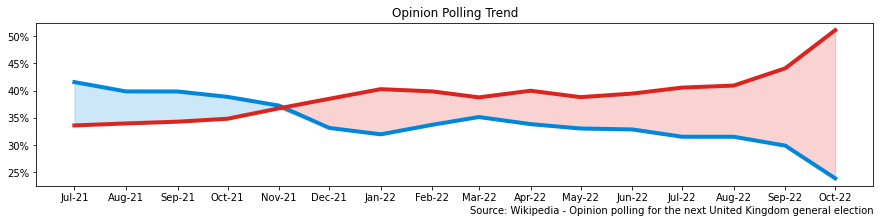

In [254]:
from scripts.constants import party_colors, major_parties
import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 3))
fig.set_facecolor('white')
ax = plt.gca()

# monthly_summary[major_parties[:2]][1:].plot(
#     ax=ax,
#     ylim=[30, 45],
#     color=party_colors,
#     linewidth=3
# )
for party in major_parties[:2]:
    plt.plot_date(
        x=monthly_summary.index[1:],
        y=monthly_summary[party][1:],
        fmt='-',
        color=party_colors[party],
        linewidth=4)

    ax.fill_between(monthly_summary.index[1:], monthly_summary[party][1:],
                    monthly_summary[major_parties[:2]].min(axis=1)[1:], color=party_colors[party], alpha=0.2)
ax.set_yticks(arange(25, 51, 5), minor=False)
major_locator = plt.matplotlib.dates.DayLocator([1])
major_fmt = plt.matplotlib.dates.DateFormatter('%b-%y')

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

plot_title = 'Opinion Polling Trend'
plt.title(plot_title)

source = 'Source: Wikipedia - Opinion polling for the next United Kingdom general election'
plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')
fig.savefig('html_outputs/monthly_trend.png', bbox_inches='tight', pad_inches=0.2)

In [255]:
monthly_summary

,conservative,labour,liberal_democrat,pollster_count,poll_count,lead,lead_value
poll_month,,,,,,,
2021-06-01,43.477778,33.233333,8.011111,9,24,con+10.2,10.244444
2021-07-01,41.560417,33.602083,9.406250,8,22,con+8.0,7.958333
2021-08-01,39.850000,33.970000,9.860000,5,16,con+5.9,5.880000
2021-09-01,39.835000,34.290000,9.393333,10,24,con+5.5,5.545000
2021-10-01,38.850000,34.833333,8.350000,9,20,con+4.0,4.016667
2021-11-01,37.240741,36.750000,9.222222,9,24,con+0.5,0.490741
2021-12-01,33.151515,38.492424,10.113636,11,28,lab+5.3,5.340909
2022-01-01,31.969444,40.263889,10.836111,12,29,lab+8.3,8.294444
2022-02-01,33.725000,39.850000,10.300000,10,23,lab+6.1,6.125000


In [256]:
import datetime

<AxesSubplot:xlabel='date_started'>

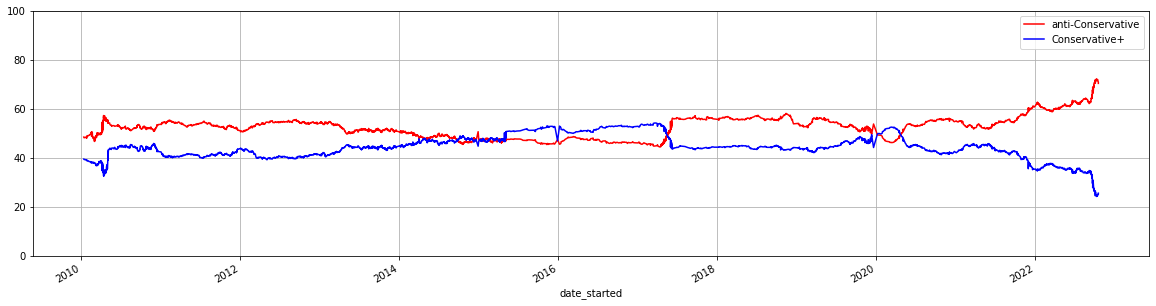

In [257]:
all_polls['anti-Conservative'] = all_polls[
    ['labour', 'liberal_democrat', 'alliance', 'change_uk', 'green', 'liberal', 'plaid_cymru',
     'scottish_national_party', 'social_democratic_party']].sum(axis=1)
all_polls['Conservative+'] = all_polls[
    ['conservative', 'brexit_party', 'reform_uk', 'united_kingdom_independence_party', 'reclaim_party']].sum(axis=1)

(all_polls
 .set_index(reporting_date)
 .rolling(window=15).mean()
 .loc[:datetime.date(2010, 1, 13)]
[['anti-Conservative', 'Conservative+']]
 .plot(
    color=['r', 'b']
    , figsize=[20, 5]
    , grid='y'
    , ylim=[0, 100]
)
)

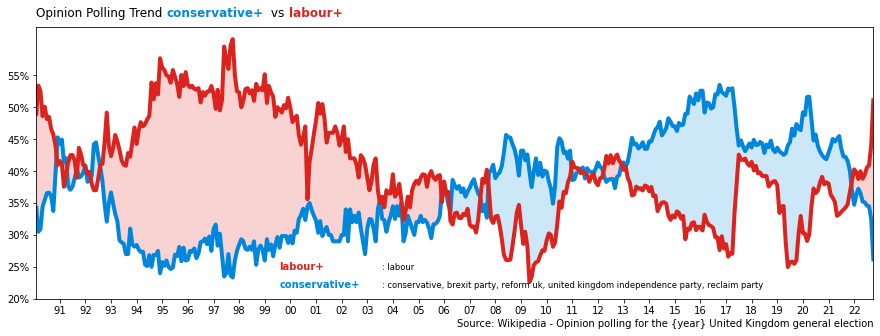

In [258]:
group_colours = {'conservative+': '#0087DC',
                 'labour+': '#DC241F',
                 }
groups = list(group_colours.keys())

# group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk','united_kingdom_independence_party', 'reclaim_party'],
#  'anti-Conservative': ['labour', 'liberal_democrat', 'alliance', 'change_uk', 'green', 'liberal', 'plaid_cymru', 'scottish_national_party', 'social_democratic_party'],
#  }

group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk', 'united_kingdom_independence_party',
                                   'reclaim_party'],
                 'labour+': ['labour'],
                 }

two_group_polls = all_polls[all_polls[reporting_date] >= datetime.datetime(1990, 1, 1)].copy()

for group, parties in group_parties.items():
    two_group_polls[group] = two_group_polls[parties].sum(axis=1)
    two_group_polls.drop(
        columns=parties,
        inplace=True,
    )

two_group_polls['poll_month'] = two_group_polls[reporting_date].apply(lambda x: x.replace(day=1))
two_group_polls = two_group_polls[[reporting_date, 'pollster', 'poll_month'] + groups]

two_group_monthly = two_group_polls.groupby(['poll_month', 'pollster'])[groups].agg(['mean', 'count'])
two_group_monthly.columns = [x if i == 0 else f'count{groups.index(x)}' for x in groups for i in range(0, 2)]
two_group_monthly.drop(columns=[f'count{groups.index(x)}' for x in groups][1:], inplace=True)
two_group_monthly.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in groups}
agg_info['count'] = ['count', 'sum']
two_group_monthly_summary = two_group_monthly.reset_index().groupby(['poll_month']).agg(agg_info)
two_group_monthly_summary.columns = groups + ['pollster_count', 'poll_count']

import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 5))
fig.set_facecolor('white')
ax = plt.gca()

for group in groups:
    plt.plot_date(
        x=two_group_monthly_summary.index[1:],
        y=two_group_monthly_summary[group][1:],
        fmt='-',
        color=group_colours[group],
        linewidth=4)

    ax.fill_between(two_group_monthly_summary.index[1:], two_group_monthly_summary[group][1:],
                    two_group_monthly_summary[groups[:2]].min(axis=1)[1:], color=group_colours[group], alpha=0.2)
ax.set_yticks(arange(20, 56, 5), minor=False)
# major_locator = plt.matplotlib.dates.DayLocator([1])
# major_fmt = plt.matplotlib.dates.DateFormatter('%b-%y')

major_locator = plt.matplotlib.dates.MonthLocator([1])
major_fmt = plt.matplotlib.dates.DateFormatter("%y")

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.set_xlim([two_group_monthly_summary.index[1], two_group_monthly_summary.index[-1]])

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

titleOffset = 0.125
renderer = fig.canvas.get_renderer()
figwidth = ax.get_window_extent().width/0.8

group_parts = [[f"{group}", group_colours[group], 'bold'] for group in groups]
titleparts = [['Opinion Polling Trend', 'k', 'book']] + [a for b in [[x, [" vs ", 'k', 'regular']] for x in group_parts]
                                                         for a in b][:-1]

for part in titleparts:
    txt = fig.text(titleOffset, 0.9, part[0], ha="left", va="bottom", size="large", color=part[1], weight=part[2])
    titleOffset += (txt.get_window_extent(renderer=renderer).width/figwidth)

# plot_title = 'Opinion Polling Trend'
# plt.title(plot_title)

source = 'Source: Wikipedia - Opinion polling for the {year} United Kingdom general election'
plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')

titleOffset = 0.15
for group, parties in group_parties.items():
    colour = group_colours[group]
    fig.text(0.35, titleOffset, group, ha="left", va="bottom", size="medium", color=colour, weight='bold')
    fig.text(0.445, titleOffset, ': ' + ', '.join(parties).replace('_', ' '), ha="left", va="bottom", size="small",
             color='k', weight='regular')
    titleOffset += 0.05
#fig.savefig('html_outputs/monthly_trend.png', bbox_inches = 'tight', pad_inches = 0.2)

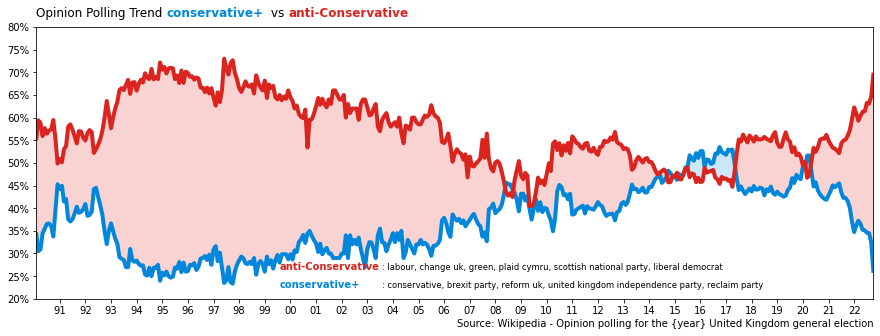

In [259]:
group_colours = {'conservative+': '#0087DC',
                 'anti-Conservative': '#DC241F',
                 }
groups = list(group_colours.keys())

# group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk','united_kingdom_independence_party', 'reclaim_party'],
#  'anti-Conservative': ['labour', 'liberal_democrat', 'alliance', 'change_uk', 'green', 'liberal', 'plaid_cymru', 'scottish_national_party', 'social_democratic_party'],
#  }

group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk', 'united_kingdom_independence_party',
                                   'reclaim_party'],
                 'anti-Conservative': ['labour', 'change_uk', 'green', 'plaid_cymru', 'scottish_national_party',
                                       'liberal_democrat'],
                 }

two_group_polls = all_polls[all_polls[reporting_date] >= datetime.datetime(1990, 1, 1)].copy()

for group, parties in group_parties.items():
    two_group_polls[group] = two_group_polls[parties].sum(axis=1)
    two_group_polls.drop(
        columns=parties,
        inplace=True,
    )

two_group_polls['poll_month'] = two_group_polls[reporting_date].apply(lambda x: x.replace(day=1))
two_group_polls = two_group_polls[[reporting_date, 'pollster', 'poll_month'] + groups]

two_group_monthly = two_group_polls.groupby(['poll_month', 'pollster'])[groups].agg(['mean', 'count'])
two_group_monthly.columns = [x if i == 0 else f'count{groups.index(x)}' for x in groups for i in range(0, 2)]
two_group_monthly.drop(columns=[f'count{groups.index(x)}' for x in groups][1:], inplace=True)
two_group_monthly.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in groups}
agg_info['count'] = ['count', 'sum']
two_group_monthly_summary = two_group_monthly.reset_index().groupby(['poll_month']).agg(agg_info)
two_group_monthly_summary.columns = groups + ['pollster_count', 'poll_count']

import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 5))
fig.set_facecolor('white')
ax = plt.gca()

for group in groups:
    plt.plot_date(
        x=two_group_monthly_summary.index[1:],
        y=two_group_monthly_summary[group][1:],
        fmt='-',
        color=group_colours[group],
        linewidth=4)

    ax.fill_between(two_group_monthly_summary.index[1:], two_group_monthly_summary[group][1:],
                    two_group_monthly_summary[groups[:2]].min(axis=1)[1:], color=group_colours[group], alpha=0.2)
ax.set_yticks(arange(20, 81, 5), minor=False)
# major_locator = plt.matplotlib.dates.DayLocator([1])
# major_fmt = plt.matplotlib.dates.DateFormatter('%b-%y')

major_locator = plt.matplotlib.dates.MonthLocator([1])
major_fmt = plt.matplotlib.dates.DateFormatter("%y")

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.set_xlim([two_group_monthly_summary.index[1], two_group_monthly_summary.index[-1]])

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

titleOffset = 0.125
renderer = fig.canvas.get_renderer()
figwidth = ax.get_window_extent().width/0.8

group_parts = [[f"{group}", group_colours[group], 'bold'] for group in groups]
titleparts = [['Opinion Polling Trend', 'k', 'book']] + [a for b in [[x, [" vs ", 'k', 'regular']] for x in group_parts]
                                                         for a in b][:-1]

for part in titleparts:
    txt = fig.text(titleOffset, 0.9, part[0], ha="left", va="bottom", size="large", color=part[1], weight=part[2])
    titleOffset += (txt.get_window_extent(renderer=renderer).width/figwidth)

# plot_title = 'Opinion Polling Trend'
# plt.title(plot_title)

source = 'Source: Wikipedia - Opinion polling for the {year} United Kingdom general election'
plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')

titleOffset = 0.15
for group, parties in group_parties.items():
    colour = group_colours[group]
    fig.text(0.35, titleOffset, group, ha="left", va="bottom", size="medium", color=colour, weight='bold')
    fig.text(0.445, titleOffset, ': ' + ', '.join(parties).replace('_', ' '), ha="left", va="bottom", size="small",
             color='k', weight='regular')
    titleOffset += 0.05
#fig.savefig('html_outputs/monthly_trend.png', bbox_inches = 'tight', pad_inches = 0.2)

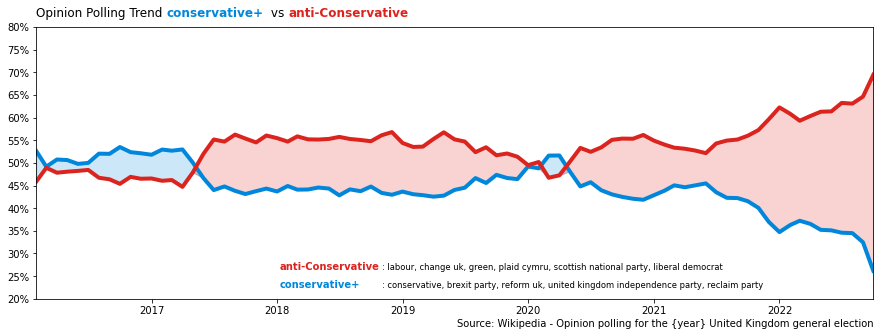

In [260]:
group_colours = {'conservative+': '#0087DC',
                 'anti-Conservative': '#DC241F',
                 }
groups = list(group_colours.keys())

# group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk','united_kingdom_independence_party', 'reclaim_party'],
#  'anti-Conservative': ['labour', 'liberal_democrat', 'alliance', 'change_uk', 'green', 'liberal', 'plaid_cymru', 'scottish_national_party', 'social_democratic_party'],
#  }

group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk', 'united_kingdom_independence_party',
                                   'reclaim_party'],
                 'anti-Conservative': ['labour', 'change_uk', 'green', 'plaid_cymru', 'scottish_national_party',
                                       'liberal_democrat'],
                 }

two_group_polls = all_polls[all_polls[reporting_date] >= datetime.datetime(2016, 1, 1)].copy()

for group, parties in group_parties.items():
    two_group_polls[group] = two_group_polls[parties].sum(axis=1)
    two_group_polls.drop(
        columns=parties,
        inplace=True,
    )

two_group_polls['poll_month'] = two_group_polls[reporting_date].apply(lambda x: x.replace(day=1))
two_group_polls = two_group_polls[[reporting_date, 'pollster', 'poll_month'] + groups]

two_group_monthly = two_group_polls.groupby(['poll_month', 'pollster'])[groups].agg(['mean', 'count'])
two_group_monthly.columns = [x if i == 0 else f'count{groups.index(x)}' for x in groups for i in range(0, 2)]
two_group_monthly.drop(columns=[f'count{groups.index(x)}' for x in groups][1:], inplace=True)
two_group_monthly.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in groups}
agg_info['count'] = ['count', 'sum']
two_group_monthly_summary = two_group_monthly.reset_index().groupby(['poll_month']).agg(agg_info)
two_group_monthly_summary.columns = groups + ['pollster_count', 'poll_count']

import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 5))
fig.set_facecolor('white')
ax = plt.gca()

for group in groups:
    plt.plot_date(
        x=two_group_monthly_summary.index[1:],
        y=two_group_monthly_summary[group][1:],
        fmt='-',
        color=group_colours[group],
        linewidth=4)

    ax.fill_between(two_group_monthly_summary.index[1:], two_group_monthly_summary[group][1:],
                    two_group_monthly_summary[groups[:2]].min(axis=1)[1:], color=group_colours[group], alpha=0.2)
ax.set_yticks(arange(20, 81, 5), minor=False)
# major_locator = plt.matplotlib.dates.DayLocator([1])
# major_fmt = plt.matplotlib.dates.DateFormatter('%b-%y')

major_locator = plt.matplotlib.dates.MonthLocator([1])
major_fmt = plt.matplotlib.dates.DateFormatter("%Y")

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.set_xlim([two_group_monthly_summary.index[1], two_group_monthly_summary.index[-1]])

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

titleOffset = 0.125
renderer = fig.canvas.get_renderer()
figwidth = ax.get_window_extent().width/0.8

group_parts = [[f"{group}", group_colours[group], 'bold'] for group in groups]
titleparts = [['Opinion Polling Trend', 'k', 'book']] + [a for b in [[x, [" vs ", 'k', 'regular']] for x in group_parts]
                                                         for a in b][:-1]

for part in titleparts:
    txt = fig.text(titleOffset, 0.9, part[0], ha="left", va="bottom", size="large", color=part[1], weight=part[2])
    titleOffset += (txt.get_window_extent(renderer=renderer).width/figwidth)

# plot_title = 'Opinion Polling Trend'
# plt.title(plot_title)

source = 'Source: Wikipedia - Opinion polling for the {year} United Kingdom general election'
plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')

titleOffset = 0.15
for group, parties in group_parties.items():
    colour = group_colours[group]
    fig.text(0.35, titleOffset, group, ha="left", va="bottom", size="medium", color=colour, weight='bold')
    fig.text(0.445, titleOffset, ': ' + ', '.join(parties).replace('_', ' '), ha="left", va="bottom", size="small",
             color='k', weight='regular')
    titleOffset += 0.05
#fig.savefig('html_outputs/monthly_trend.png', bbox_inches = 'tight', pad_inches = 0.2)

In [261]:
one_year_polls['poll_month'] = one_year_polls[reporting_date].apply(lambda x: x.replace(day=1))

In [262]:
kantar_polls = all_polls.query('pollster == "Kantar Public" and date_concluded> "2019-01-01"').copy()
other_polls = all_polls.query('pollster != "Kantar Public" and date_concluded> "2019-01-01"').copy()

In [263]:
kantar_polls['poll_month'] = kantar_polls[reporting_date].apply(lambda x: x.replace(day=1))
other_polls['poll_month'] = other_polls[reporting_date].apply(lambda x: x.replace(day=1))

In [264]:
other_pollster_monthly_summary = other_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
other_pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i
                                          in
                                          range(0, 2)]
other_pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
other_pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
other_monthly_summary = other_pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
other_monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [265]:
kantar_pollster_monthly_summary = kantar_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
kantar_pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for
                                           i in
                                           range(0, 2)]
kantar_pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:],
                                     inplace=True)
kantar_pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
kantar_monthly_summary = kantar_pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
kantar_monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [266]:
other_monthly_summary[['kantar_con', 'kantar_lab']] = kantar_monthly_summary[['conservative', 'labour']]

In [267]:
other_monthly_summary.to_clipboard(sep='\t')

In [268]:
general_elections = all_polls.query('pollster=="General Election"')
general_election_dates = list(general_elections.date_concluded.unique())
#general_elections = general_elections[general_elections.date_concluded > datetime.datetime(2016,1,1)]

In [269]:
for ge in general_election_dates[::-1]:
    if ge < np.datetime64('2016-01-01'):
        continue

    print(ge)

2017-06-08T00:00:00.000000000
2019-12-12T00:00:00.000000000


In [270]:
general_elections[general_elections.date_concluded == ge]

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,alliance,...,others,lead,lead_value,anti_conservative,maj_lead,maj_lead_in_row,dd_lead,dd_in_row,anti-Conservative,Conservative+
709,2019-12-12,2019-12-12,General Election,NaN,GB,–,44.7,33.0,11.8,NaN,...,1.0,con+11.7,11.7,52.1,0.0,0,1.0,45,52.1,46.9
710,2019-12-12,2019-12-12,General Election,2019 general election,GB,–,44.7,32.9,11.8,NaN,...,2.2,con+11.8,11.8,51.5,0.0,0,1.0,45,51.5,46.8
711,2019-12-12,2019-12-12,General Election,2019 general election,UK,–,43.6,32.1,11.6,NaN,...,3.7,con+11.5,11.5,50.3,0.0,0,1.0,45,50.3,45.6


In [271]:
all_polls.query('liberal_democrat + 10 > conservative')

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,alliance,...,others,lead,lead_value,anti_conservative,maj_lead,maj_lead_in_row,dd_lead,dd_in_row,anti-Conservative,Conservative+
10,2022-10-20,2022-10-21,YouGov,The Times,GB,1700,19.0,56.0,10.0,NaN,...,1.0,lab+37.0,37.0,75.0,1.0,17,1.0,48,75.0,24.0
12,2022-10-20,2022-10-20,PeoplePolling,GB News,GB,1237,14.0,53.0,11.0,NaN,...,5.0,lab+39.0,39.0,75.0,1.0,17,1.0,48,75.0,19.0
15,2022-10-19,2022-10-19,Redfield & Wilton Strategies,NaN,GB,2500,19.0,55.0,12.0,NaN,...,1.0,lab+36.0,36.0,75.0,1.0,17,1.0,48,75.0,23.0
18,2022-10-16,2022-10-16,Redfield & Wilton Strategies,NaN,GB,2000,20.0,56.0,11.0,NaN,...,1.0,lab+36.0,36.0,76.0,1.0,17,1.0,48,76.0,22.0
816,2019-09-25,2019-09-25,Survation,Daily Mail,UK,1011,27.0,24.0,22.0,NaN,...,4.0,con+3.0,3.0,53.0,0.0,0,0.0,0,53.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,1993-06-11,1993-06-11,NOP,Independent on Sunday,NaN,NaN,27.0,42.0,26.0,NaN,...,NaN,lab+15.0,15.0,68.0,0.0,0,1.0,3,68.0,27.0
4604,1993-06-05,1993-06-05,ICM Research,Guardian,NaN,NaN,31.0,38.0,26.0,NaN,...,NaN,lab+7.0,7.0,64.0,0.0,0,0.0,0,64.0,31.0
4605,1993-05-31,1993-05-31,Gallup,Telegraph,NaN,NaN,25.0,49.0,23.0,NaN,...,NaN,lab+24.0,24.0,72.0,0.0,0,1.0,2,72.0,25.0
4606,1993-05-24,1993-05-24,Ipsos MORI,Times,NaN,NaN,28.0,44.0,24.0,NaN,...,NaN,lab+16.0,16.0,68.0,0.0,0,1.0,2,68.0,28.0


In [272]:
all_polls.query('labour>56')

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,alliance,...,others,lead,lead_value,anti_conservative,maj_lead,maj_lead_in_row,dd_lead,dd_in_row,anti-Conservative,Conservative+
13,2022-10-20,2022-10-20,Omnisis,NaN,GB,1382,22.0,57.0,7.0,NaN,...,3.0,lab+35.0,35.0,72.0,1.0,17,1.0,48,72.0,25.0
4259,1999-01-06,1999-01-12,NOP,Evening Standard,NaN,1600,25.0,57.0,12.0,NaN,...,6.0,lab+32.0,32.0,69.0,1.0,7,1.0,133,69.0,25.0
4271,1998-09-24,1998-09-30,Gallup,The Daily Telegraph,NaN,1028,23.0,57.0,15.0,NaN,...,5.0,lab+34.0,34.0,72.0,1.0,8,1.0,133,72.0,23.0
4304,1997-11-27,1997-12-03,Gallup,The Daily Telegraph,NaN,1011,21.0,57.0,17.0,NaN,...,5.0,lab+36.0,36.0,74.0,1.0,20,1.0,133,74.0,21.0
4308,1997-10-30,1997-11-04,Gallup,The Daily Telegraph,NaN,1021,23.0,63.0,11.0,NaN,...,4.0,lab+40.0,40.0,74.0,1.0,20,1.0,133,74.0,23.0
4309,1997-10-24,1997-10-27,Ipsos MORI,The Times,NaN,1772,24.0,60.0,12.0,NaN,...,4.0,lab+36.0,36.0,72.0,1.0,20,1.0,133,72.0,24.0
4310,1997-10-06,1997-10-06,ICM Research,The Guardian,NaN,1211,23.0,59.0,13.0,NaN,...,4.0,lab+36.0,36.0,72.0,1.0,20,1.0,133,72.0,23.0
4311,1997-09-25,1997-10-01,Gallup,The Daily Telegraph,NaN,1014,22.0,60.0,14.0,NaN,...,4.0,lab+38.0,38.0,74.0,1.0,20,1.0,133,74.0,22.0
4312,1997-09-26,1997-09-29,Ipsos MORI,The Times,NaN,1916,25.0,59.0,13.0,NaN,...,3.0,lab+34.0,34.0,72.0,1.0,20,1.0,133,72.0,25.0
4313,1997-09-04,1997-09-08,ICM Research,The Guardian,NaN,1206,24.0,60.0,10.0,NaN,...,6.0,lab+36.0,36.0,70.0,1.0,20,1.0,133,70.0,24.0


In [273]:
GEs_to_use = [

]

In [274]:
all_polls.query('pollster=="Techne UK"')

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,alliance,...,others,lead,lead_value,anti_conservative,maj_lead,maj_lead_in_row,dd_lead,dd_in_row,anti-Conservative,Conservative+
1,2022-10-26,2022-10-27,Techne UK,NaN,UK,1626,26.0,50.0,10.0,NaN,...,5.0,lab+24.0,24.0,69.0,1.0,2,1.0,48,69.0,26.0
14,2022-10-19,2022-10-20,Techne UK,NaN,UK,1632,22.0,53.0,11.0,NaN,...,5.0,lab+31.0,31.0,73.0,1.0,17,1.0,48,73.0,22.0
21,2022-10-12,2022-10-13,Techne UK,NaN,UK,1626,25.0,49.0,11.0,NaN,...,5.0,lab+24.0,24.0,70.0,0.0,0,1.0,48,70.0,25.0
33,2022-10-05,2022-10-06,Techne UK,NaN,UK,1636,26.0,48.0,10.0,NaN,...,6.0,lab+22.0,22.0,68.0,0.0,0,1.0,48,68.0,26.0
40,2022-09-28,2022-09-29,Techne UK,NaN,UK,1625,27.0,47.0,11.0,NaN,...,5.0,lab+20.0,20.0,68.0,0.0,0,1.0,48,68.0,27.0
55,2022-09-21,2022-09-22,Techne UK,NaN,UK,1639,34.0,41.0,11.0,NaN,...,5.0,lab+7.0,7.0,61.0,0.0,0,0.0,0,61.0,34.0
61,2022-09-14,2022-09-15,Techne UK,NaN,UK,1647,35.0,41.0,10.0,NaN,...,5.0,lab+6.0,6.0,60.0,0.0,0,0.0,0,60.0,35.0
67,2022-09-07,2022-09-08,Techne UK,NaN,GB,1628,34.0,42.0,11.0,NaN,...,5.0,lab+8.0,8.0,61.0,0.0,0,0.0,0,61.0,34.0
73,2022-09-01,2022-09-02,Techne UK,NaN,GB,1628,32.0,42.0,12.0,NaN,...,5.0,lab+10.0,10.0,63.0,0.0,0,1.0,7,63.0,32.0
81,2022-08-24,2022-08-25,Techne UK,NaN,GB,1630,33.0,41.0,11.0,NaN,...,5.0,lab+8.0,8.0,62.0,0.0,0,0.0,0,62.0,33.0


In [275]:
break

SyntaxError: 'break' outside loop (Temp/ipykernel_69884/370545404.py, line 1)

In [ ]:
import pandas as pd
import requests
from io import StringIO

url = 'https://www.markpack.org.uk/files/2022/07/PollBase-Q2-2022.xlsx'
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0"}
req = requests.get(url, headers=headers)



In [ ]:
data = StringIO(req.content)

In [ ]:
pollbase = pd.read_excel(req.content, sheet_name=1)

In [ ]:
pollbase

In [ ]:
all_polls['poll_month'] = all_polls['date_concluded'].apply(lambda x: x.replace(day=1))

In [ ]:
pollster_monthly_summary = all_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i in
                                    range(0, 2)]
pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
monthly_summary = pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [ ]:
monthly_summary.query('conservative<31.5')

In [ ]:
monthly_summary.query('(labour-conservative)>9.3')